<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: ZTF photometry

In [1]:
import io
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Difference image PSF-fit magnitude

Let's start with the ZTF alerts processed by Fink. By default, each alert packet includes the difference image PSF-fit magnitude:

In [2]:
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF18abktckv',
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_magpsf = pd.read_json(io.BytesIO(r.content))

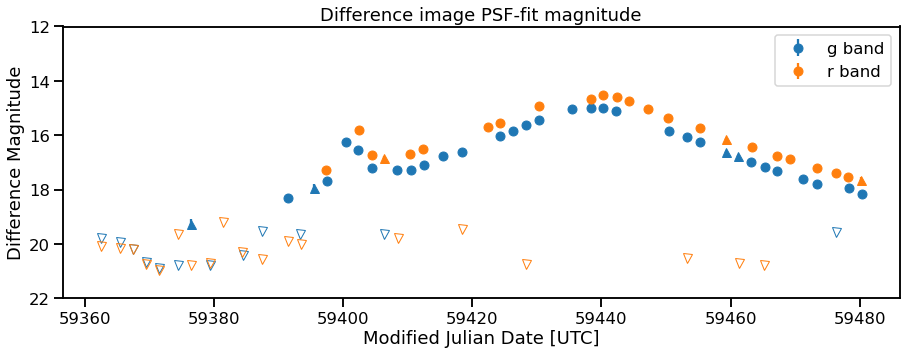

In [4]:
mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid'
    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    plt.plot(
        pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
        pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');

_Circles (&#9679;) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (&#9650;) represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by Fink science modules. Lower triangles (&#9661;) represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts._

## DC mag

In [16]:
from fink_science.conversion import dc_mag

# Take only valid measurements
pdf_magpsf_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

# Use DC magnitude instead of difference mag
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf_magpsf_valid['i:fid'].astype(int).values,
            pdf_magpsf_valid['i:magpsf'].astype(float).values,
            pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
            pdf_magpsf_valid['i:magnr'].astype(float).values,
            pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
            pdf_magpsf_valid['i:magzpsci'].astype(float).values,
            pdf_magpsf_valid['i:isdiffpos'].values
        )
    ]
)

pdf_magpsf_valid['i:mag_dc'] = mag_dc
pdf_magpsf_valid['i:err_dc'] = err_dc

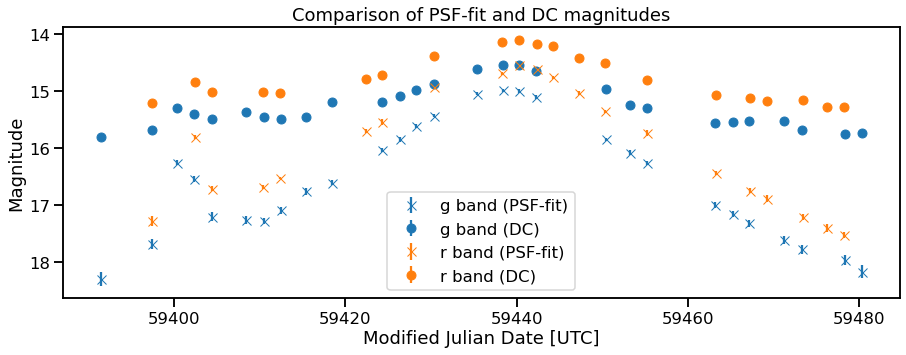

In [20]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

## ZTF data release data

In [18]:
ra0 = np.mean(pdf_magpsf_valid['i:ra'].values)
dec0 = np.mean(pdf_magpsf_valid['i:dec'].values)

r = requests.post(
    'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves', 
    data={'POS': 'CIRCLE {} {} 0.0004'.format(ra0, dec0), 
          'BAD_CATFLAGS_MASK': 32768, 
          'FORMAT': 'csv'
         }
)

pdf_ZTF = pd.read_csv(io.StringIO(r.text))

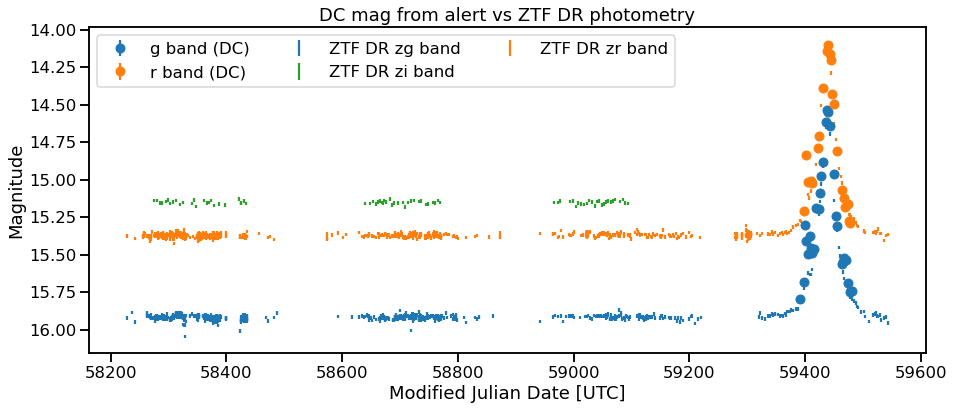

In [25]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

f = pdf_ZTF['catflags'] == 0
colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF[f]['filtercode']):
    maskFilt = pdf_ZTF[f]['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[f][maskFilt]['mjd'], 
        pdf_ZTF[f][maskFilt]['mag'], 
        pdf_ZTF[f][maskFilt]['magerr'], 
        ls='', color=colordic[filt],
        label='ZTF DR {} band'.format(filt))

plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title('DC mag from alert vs ZTF DR photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

Let's zoom on the peak:

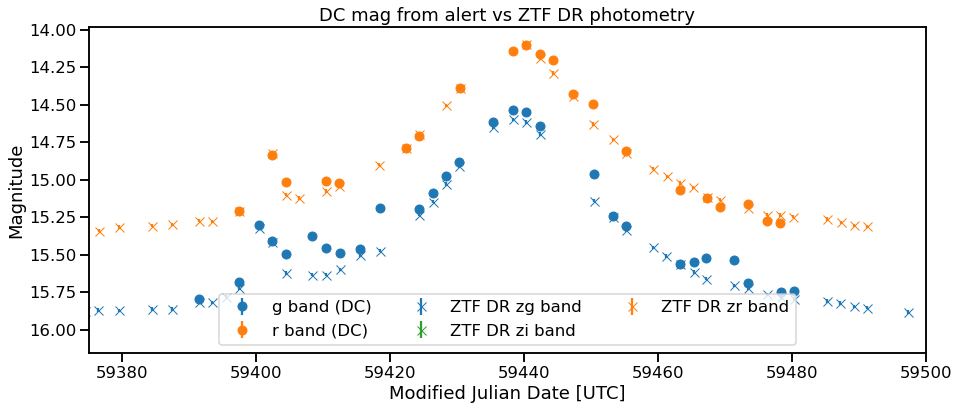

In [29]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

f = pdf_ZTF['catflags'] == 0
colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF[f]['filtercode']):
    maskFilt = pdf_ZTF[f]['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[f][maskFilt]['mjd'], 
        pdf_ZTF[f][maskFilt]['mag'], 
        pdf_ZTF[f][maskFilt]['magerr'], 
        ls='', color=colordic[filt], marker='x',
        label='ZTF DR {} band'.format(filt))

plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title('DC mag from alert vs ZTF DR photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude')
plt.xlim(59375, 59500);

## Forced photometry

In [32]:
pdf = pd.read_csv('forcedphotometry_req00100242_lc.txt', comment='#', sep=' ')

pdf = pdf\
    .drop(columns=['Unnamed: 0'])\
    .rename(lambda x: x.split(',')[0], axis='columns')

In [5]:
pdf.columns

Index(['index', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci',
       'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci',
       'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc',
       'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim',
       'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux',
       'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq',
       'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap',
       'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc',
       'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend',
       'procstatus'],
      dtype='object')

The default data is difference image PSF-fit flux (similar to alerts)

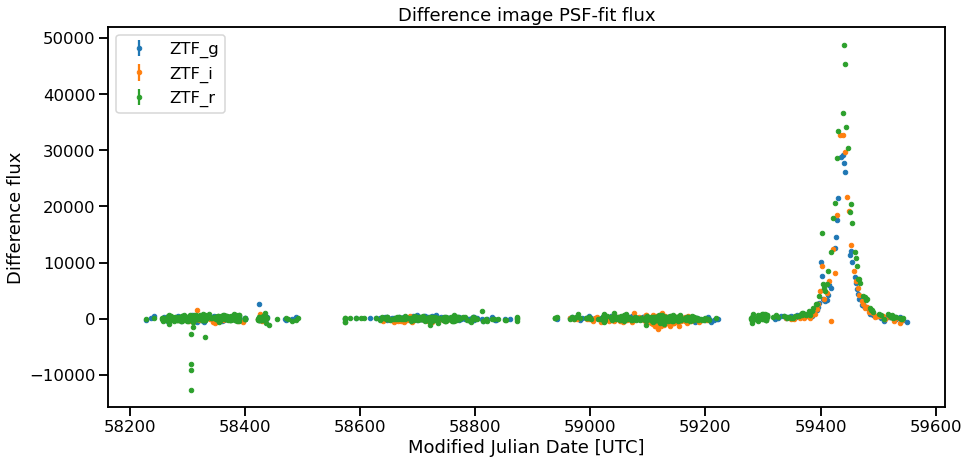

In [48]:
fig = plt.figure(figsize=(15, 7))
for filt in np.unique(pdf['filter']):
    mask = pdf['filter'] == filt
    sub = pdf[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['forcediffimflux'], 
        sub['forcediffimfluxunc'], 
        ls='', 
        marker='.',
        label=filt
    )
plt.legend()
plt.title('Difference image PSF-fit flux')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference flux');
# plt.xlim(59350, 59550)

Generating absolute-photometry lightcurves for variable sources:

In [34]:
def diff_phot(forcediffimflux, forcediffimfluxunc, zpdiff, SNT=3, SNU=5, set_to_nan=True):
    """
    """
    if (forcediffimflux / forcediffimfluxunc) > SNT:
        # we have a confident detection, compute and plot mag with error bar:
        mag = zpdiff - 2.5 * np.log10(forcediffimflux)
        err = 1.0857 * forcediffimfluxunc / forcediffimflux
    else:
        # compute flux upper limit and plot as arrow:
        if not set_to_nan:
            mag = zpdiff - 2.5 * np.log10(SNU * forcediffimfluxunc)
        else:
            mag = np.nan
        err = np.nan
        
    return mag, err
    
def apparent_flux(magpsf, sigmapsf, magnr, sigmagnr, magzpsci):
    """ Compute apparent flux from difference magnitude supplied by ZTF
    This was heavily influenced by the computation provided by Lasair:
    https://github.com/lsst-uk/lasair/blob/master/src/alert_stream_ztf/common/mag.py
    Paramters
    ---------
    fid
        filter, 1 for green and 2 for red
    magpsf,sigmapsf; floats
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr: floats
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    magzpsci: float
        Magnitude zero point for photometry estimates
    isdiffpos: str
        t or 1 => candidate is from positive (sci minus ref) subtraction;
        f or 0 => candidate is from negative (ref minus sci) subtraction

    Returns
    --------
    dc_flux: float
        Apparent magnitude
    dc_sigflux: float
        Error on apparent magnitude
    """
    if magpsf is None:
        return None, None

    # reference flux and its error
    magdiff = magzpsci - magnr
    if magdiff > 12.0:
        magdiff = 12.0
    ref_flux = 10**(0.4 * magdiff)
    ref_sigflux = (sigmagnr / 1.0857) * ref_flux

    magdiff = magzpsci - magpsf
    if magdiff > 12.0:
        magdiff = 12.0
    difference_flux = 10**(0.4 * magdiff)
    difference_sigflux = (sigmapsf / 1.0857) * difference_flux

    dc_flux = ref_flux + difference_flux

    # assumes errors are independent. Maybe too conservative.
    dc_sigflux = np.sqrt(difference_sigflux**2 + ref_sigflux**2)

    return dc_flux, dc_sigflux

def dc_mag(magpsf, sigmapsf, magnr, sigmagnr, magzpsci):
    """ Compute apparent magnitude from difference magnitude supplied by ZTF
    Parameters
    Stolen from Lasair.
    ----------
    fid
        filter, 1 for green and 2 for red
    magpsf,sigmapsf
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    magzpsci
        Magnitude zero point for photometry estimates
    isdiffpos
        t or 1 => candidate is from positive (sci minus ref) subtraction;
        f or 0 => candidate is from negative (ref minus sci) subtraction
    """
    dc_flux, dc_sigflux = apparent_flux(
        magpsf, sigmapsf, magnr, sigmagnr, magzpsci
    )

    # apparent mag and its error from fluxes
    if (dc_flux == dc_flux) and dc_flux > 0.0:
        dc_mag = magzpsci - 2.5 * np.log10(dc_flux)
        dc_sigmag = dc_sigflux / dc_flux * 1.0857
    else:
        dc_mag = np.nan
        dc_sigmag = np.nan

    return dc_mag, dc_sigmag

difference image PSF-fit flux to difference image PSF-fit magnitude:

In [35]:
magpsf, sigmapsf = np.transpose(
    [
        diff_phot(*args) for args in zip(
            pdf['forcediffimflux'],
            pdf['forcediffimfluxunc'].values,
            pdf['zpdiff'].values,
        )
    ]
)

difference image PSF-fit magnitude to absolute magnitude (DC):

In [36]:
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            magpsf,
            sigmapsf,
            pdf['nearestrefmag'].values,
            pdf['nearestrefmagunc'].values,
            pdf['zpmaginpsci'].values,
        )
    ]
)

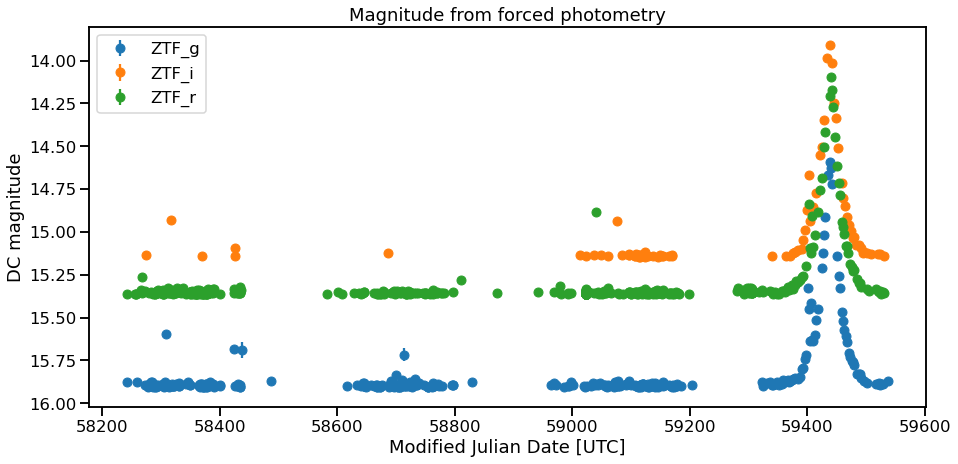

In [51]:
fig = plt.figure(figsize=(15, 7))
for filt in np.unique(pdf['filter']):
    mask = pdf['filter'] == filt
    sub = pdf[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5), 
        mag_dc[mask], 
        err_dc[mask], 
        ls='', 
        marker='o',
        label=filt
    )

fig.gca().invert_yaxis()
plt.legend();
plt.title('Magnitude from forced photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('DC magnitude');
# plt.xlim(59350, 59550)

We can further clean the data by taking only points with no flag:

(59350.0, 59550.0)

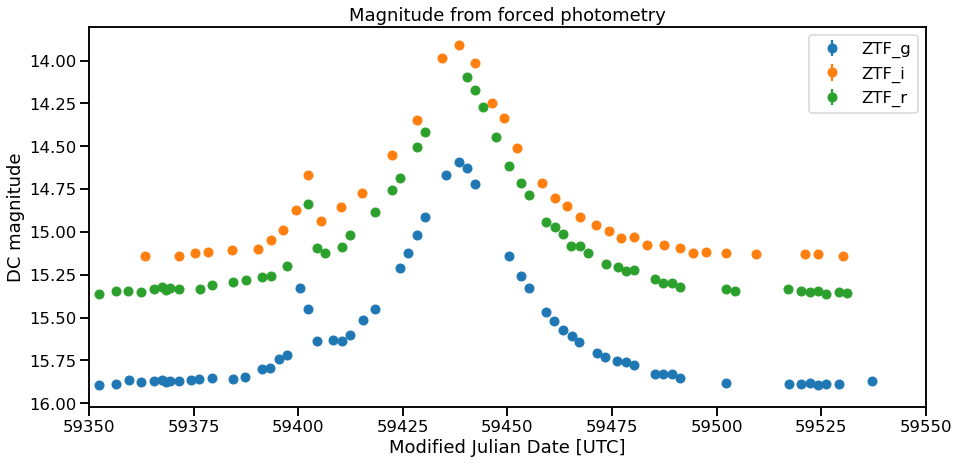

In [62]:
fig = plt.figure(figsize=(15, 7))

for filt in np.unique(pdf['filter']):
    mask = pdf['filter'] == filt
    
    # Keep onluy measurements with flag = 0
    mask *= pdf['infobitssci'] == 0
    
    sub = pdf[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5), 
        mag_dc[mask], 
        err_dc[mask], 
        ls='', 
        marker='o',
        label=filt
    )

fig.gca().invert_yaxis()
plt.legend();
plt.title('Magnitude from forced photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('DC magnitude');
# plt.xlim(59350, 59550)

## Comparing all DC measurements

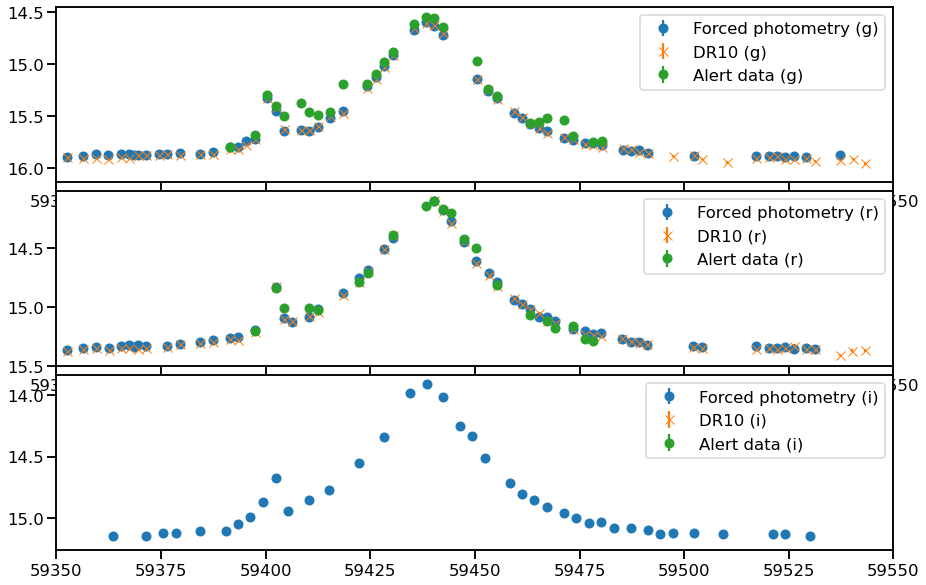

In [80]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))

gs = GridSpec(3, 1, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

axes = [ax1, ax2, ax3]

filt_DR = {1: 'zg', 2: 'zr', 3: 'zi'}
filt_forced = {1: 'ZTF_g', 2: 'ZTF_r', 3: 'ZTF_i'}
names = ['g', 'r', 'i']

for index in range(len(axes)):
    # forced photometry
    mask = pdf['filter'] == filt_forced[index + 1]
    mask *= pdf['infobitssci'] == 0
    
    axes[index].errorbar(
        pdf[mask]['jd'].apply(lambda x: x - 2400000.5), 
        mag_dc[mask], 
        err_dc[mask], 
        ls='', 
        marker='o',
        label='Forced photometry ({})'.format(names[index])
    )
    
    # Data release
    f = pdf_ZTF['catflags'] == 0
    maskFilt = pdf_ZTF[f]['filtercode'] == filt_DR[index + 1]
    axes[index].errorbar(
        pdf_ZTF[f][maskFilt]['mjd'], 
        pdf_ZTF[f][maskFilt]['mag'], 
        pdf_ZTF[f][maskFilt]['magerr'], 
        ls='', marker='x',
        label='DR10 ({})'.format(names[index])
    )
    
    # Alert
    maskFilt = pdf_magpsf_valid['i:fid'] == index + 1
    axes[index].errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        label='Alert data ({})'.format(names[index])
    )
    
    
    axes[index].legend()
    axes[index].invert_yaxis()
    axes[index].set_xlim(59350, 59550)

Mama mia, 3 things called the same, and not giving exactly the same result... But close though.